# PySpark - Preparing the Data For Modeling

## Introduction

This project aims to explore the methods for preparing the dataset for modeling purposes. It is important to note that any dataset is dirty until proven otherwise and that it should be proven to be sufficiently clean before using it. However, no dataset can be entirely clean. Below will list some of the problems that can occur in a dataset. Majority of the time, 80% of the work is getting familiar and cleaning up the dataset. The remaining 20% would be building the model.

For this project, the dataset used will only consist of 22 records, as this is to get a feel for data cleaning with PySpark and should be transferable to other datasets.

## Problems that a Dataset can have:
- __Duplicated Observations__: These types of duplication comes from systemic and operator's faults.
- __Missing Observations__: These types of errors can come about due to sensor problems, data corruption or unwilling participant that would not provide answers.
- __Anomalous Observations__: Observations that stands out when compared to the rest of the dataset. Like Outliers.
- __Encoding__: This is when text fields are not normalised, in different languages, gibberish text inputs, or when date and date time fields were not encoded similarly.
- __Untrustworthy answers__: These are true when it comes to surveys. When the response is a lie for any number of reasons. This type is much harder to work with and clean up.


## Breakdown of this Notebook

- Handling Duplicates in data records
- Handling missing observations in dataset
- Handling outliers
- Exploring the descriptive statistics
- Computing Correlations
- Drawing Histograms to describe the data
- Visualising the interactions between features


## 1 PySpark Machine Configuration:

Here it only uses two processing cores from the CPU, and it set up by the following code.

In [1]:
%%configure
{
    "executorCores" : 4
}

In [2]:
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2 Setup the Correct Directory:

In [3]:
import os

# Change the Path:
path = '++++your working directory here++++/Datasets/'
os.chdir(path)
folder_pathway = os.getcwd()

# print(folder_pathway)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3 Create the Dataset: 22 samples

In [4]:
# Define the Dirty Dataset:
dirty_data = spark.createDataFrame(
    [(1,'Porsche','Boxster S','Turbo',2.5,4,22,None),
     (2,'Aston Martin','Vanquish','Aspirated',6.0,12,16,None),
     (3,'Porsche','911 Carrera 4S Cabriolet','Turbo',3.0,6,24,None),
     (3,'General Motors','SPARK ACTIV','Aspirated',1.4,None,32,None),
     (5,'BMW','COOPER S HARDTOP 2 DOOR','Turbo',2.0,4,26,None),
     (6,'BMW','330i','Turbo',2.0,None,27,None),
     (7,'BMW','440i Coupe','Turbo',3.0,6,23,None),
     (8,'BMW','440i Coupe','Turbo',3.0,6,23,None),
     (9,'Mercedes-Benz',None,None,None,None,27,None),
     (10,'Mercedes-Benz','CLS 550','Turbo',4.7,8,21,79231),
     (11,'Volkswagen','GTI','Turbo',2.0,4,None,None),
     (12,'Ford Motor Company','FUSION AWD','Turbo',2.7,6,20,None),
     (13,'Nissan','Q50 AWD RED SPORT','Turbo',3.0,6,22,None),
     (14,'Nissan','Q70 AWD','Aspirated',5.6,8,18,None),
     (15,'Kia','Stinger RWD','Turbo',2.0,4,25,None),
     (16,'Toyota','CAMRY HYBRID LE','Aspirated',2.5,4,46,None),
     (16,'Toyota','CAMRY HYBRID LE','Aspirated',2.5,4,46,None),
     (18,'FCA US LLC','300','Aspirated',3.6,6,23,None),
     (19,'Hyundai','G80 AWD','Turbo',3.3,6,20,None),
     (20,'Hyundai','G80 AWD','Turbo',3.3,6,20,None),
     (21,'BMW','X5 M','Turbo',4.4,8,18,121231),
     (22,'GE','K1500 SUBURBAN 4WD','Aspirated',5.3,8,18,None) ],
    schema = ['Id','Manufacturer','Model','EngineType','Displacement',
     'Cylinders','FuelEconomy','MSRP'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Inspect:
dirty_data.take(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(Id=1, Manufacturer='Porsche', Model='Boxster S', EngineType='Turbo', Displacement=2.5, Cylinders=4, FuelEconomy=22, MSRP=None)]

## 4 Handling duplicates of data records:

It can be very hard to spot duplicates of data and these happen all the time. PySpark DataFrame have a method to help remove these duplicates called .dropDuplicates() transformation function.

In [6]:
# First is to check for duplicated rows:
dirty_data.count(), dirty_data.distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(22, 21)

#### From this "(22, 21)" output, it can be determined that there is one record of data that has a duplicate.

#### To check which record it is:
- First, use the .groupBy() function to define which of the dataset columns to aggregate. Here all the columns were chosen.
- Next, count the number of times these records occur with the .count() function.
- Next, use the .filter() method to select all of the rows in the dataset that occurs more than once.
- Lastly, print these records out with the .show() function.

In [7]:
# Inspect the dataset for duplicates:
(
    dirty_data
    .groupBy(dirty_data.columns)
    .count()
    .filter('count > 1')
    .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+------------+---------------+----------+------------+---------+-----------+----+-----+
| Id|Manufacturer|          Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|count|
+---+------------+---------------+----------+------------+---------+-----------+----+-----+
| 16|      Toyota|CAMRY HYBRID LE| Aspirated|         2.5|        4|         46|null|    2|
+---+------------+---------------+----------+------------+---------+-----------+----+-----+

It can be seen that __"Id 16"__ is the duplicate record.

#### Next is to proceed in removing the duplicate row:

In [8]:
# Remove the duplicates:
fully_removed_dat = dirty_data.dropDuplicates()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 4.1 Duplicates: data IDs

If the data is collected over time, it can be possible that the same data would be recorded with diffrent IDs. 

#### To check for Duplicate IDs:
- First groupBy all the columns except for the "Id" column.
- Next, is to count the number of records.
- Next, is to extract the records that has a duplicate count. ("count > 1")
- Finally, is to print out the data.

In [9]:
# Inspect if the Dataset has duplicate IDs:
(
    fully_removed_dat
    .groupBy( [col for col in fully_removed_dat.columns if col != 'Id'] )
    .count()
    .filter('count > 1')
    .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----------+----------+------------+---------+-----------+----+-----+
|Manufacturer|     Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|count|
+------------+----------+----------+------------+---------+-----------+----+-----+
|         BMW|440i Coupe|     Turbo|         3.0|        6|         23|null|    2|
|     Hyundai|   G80 AWD|     Turbo|         3.3|        6|         20|null|    2|
+------------+----------+----------+------------+---------+-----------+----+-----+

#### Check the count similar to the previous section:

In [10]:
# Save the data as a separate copy:
no_ids_dat = (
    fully_removed_dat
    .select( [col for col in fully_removed_dat.columns if col != "Id"] )
)

# Compare the count:
no_ids_dat.count(), no_ids_dat.distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(21, 19)

#### From the output "(21, 19)", it shows that there are 4 duplicate records (or 2 duplicate IDs) in the dataset.

In [11]:
# Remove these duplicates:
id_removed_dat = fully_removed_dat.dropDuplicates(
    subset = [col for col in fully_removed_dat.columns if col != "Id"]
)

# Count the number of rows:
id_removed_dat.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

19

## 4.2 Duplicates: ID Collisions.

At this point, after removing duplicates from the previous section, there may still be remaining duplicate IDs that are collisions.

These may arise for multiple reasons such as:
- Instrumental error
- Insufficient data structure to store IDs data
- IDs representing some hash function of the record elements
- Arising collisions due to choice of hash function.

### Import the required Library:

In [12]:
import pyspark.sql.functions as f

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Check if the dataset has Collisions:

Rather than segmenting the operations as in the previous section, here, the code will execute all the required operations in one go.

To do this:
- Use the .count() method to count all the records that are of non-null values in a specified column.
- Next, use the .countDistinct() method to return a distinct count of the vlaues in the specifed column. 
- Alias both with different names for the columns.

In [13]:
id_removed_dat.agg(
    f.count('Id').alias('CountOfIDs'),
    f.countDistinct('Id').alias('CountOfDistinctIDs')
).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+
|CountOfIDs|CountOfDistinctIDs|
+----------+------------------+
|        19|                18|
+----------+------------------+

#### Here, it can be seen that there are 2 records with the same IDs.

### Check which IDs are duplicated in the Dataset:

In [14]:
(
    id_removed_dat
    .groupBy('Id')
    .count()
    .filter('count > 1')
    .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----+
| Id|count|
+---+-----+
|  3|    2|
+---+-----+

#### Here it can be seen that ID 3 has duplicates.

## Examine the row that is ID 3:

In [15]:
(
    id_removed_dat
    .filter('Id == 3')
    .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------+--------------------+----------+------------+---------+-----------+----+
| Id|  Manufacturer|               Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|
+---+--------------+--------------------+----------+------------+---------+-----------+----+
|  3|General Motors|         SPARK ACTIV| Aspirated|         1.4|     null|         32|null|
|  3|       Porsche|911 Carrera 4S Ca...|     Turbo|         3.0|        6|         24|null|
+---+--------------+--------------------+----------+------------+---------+-----------+----+

#### Here the records are not the same, however, they do share the same ID number (= 3).  To fix this, a new ID should be created that will be unique.

### To do this:
There is a PySpark SQL function called .monotonically_increasing_id() that will create a unique stream of IDs. 

Where it will:
- Create an alias of the ID column 

NOTE: this method is good for dataset that are less than 1 billion partitions and the records have to be less than 8 billion recrods in each of the partitions.

In [16]:
# Apply the fix:
new_id_dat = (
    id_removed_dat
    .select(
        [f.monotonically_increasing_id().alias('Id')] + 
        [col for col in id_removed_dat.columns if col != "Id"]
    )
)

# Inspect:
new_id_dat.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------------------+--------------------+----------+------------+---------+-----------+------+
|           Id|      Manufacturer|               Model|EngineType|Displacement|Cylinders|FuelEconomy|  MSRP|
+-------------+------------------+--------------------+----------+------------+---------+-----------+------+
|   8589934592|    General Motors|         SPARK ACTIV| Aspirated|         1.4|     null|         32|  null|
| 188978561024|     Mercedes-Benz|             CLS 550|     Turbo|         4.7|        8|         21| 79231|
| 197568495616|     Mercedes-Benz|                null|      null|        null|     null|         27|  null|
| 206158430208|Ford Motor Company|          FUSION AWD|     Turbo|         2.7|        6|         20|  null|
| 438086664192|               BMW|COOPER S HARDTOP ...|     Turbo|         2.0|        4|         26|  null|
| 523986010112|      Aston Martin|            Vanquish| Aspirated|         6.0|       12|         16|  null|
| 721554505728|    

## 5 Handling Missing data observations:

Missing data can be very common amongst datasets. Here, the dataset used will be "new_id_dat" from the previous section.

## 5.1 Check the percentage of the data that is Missing:

Each row and column will be checked for missing records. From these missing values, it will be determined what data is kept and what will be dropped, or potentially impute.

### Calc the number of missing observations in the ROWS:

To do this:
- It is easier to work with RDDs and loop through each of the element to count the missing values.
- First, access the RDD of the new_id_dat DataFrame and proceed with the .map() function.
- In the .map() function, loop through each row to extract the 'Id' and count the missing values with "sum([c == None for c in row])"
- The output of the .map() will be: Id, count of missing values.
- Next, select mssing values that has a count of more than 1 with .filter() function.
- Next, .collect() these records.
- Lastly, create a simple DataFrame using the .orderBy() function to show the records that have missing values and in descending order.

In [17]:
(
    spark.createDataFrame(
        new_id_dat
        .rdd
        .map(
            lambda row: (row['Id'], sum([c == None for c in row]))
        )
        .filter(lambda el: el[1] > 1)
        .collect()
        , ['Id', 'CountMissing']
    )
    .orderBy('CountMissing', ascending=False)
    .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------+
|          Id|CountMissing|
+------------+------------+
|197568495616|           5|
|  8589934592|           2|
|919123001344|           2|
|721554505728|           2|
+------------+------------+

In [18]:
# Inspect the records: that have the highest missing values.
(
    new_id_dat
    .where('Id == 197568495616')
    .show()
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-------------+-----+----------+------------+---------+-----------+----+
|          Id| Manufacturer|Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|
+------------+-------------+-----+----------+------------+---------+-----------+----+
|197568495616|Mercedes-Benz| null|      null|        null|     null|         27|null|
+------------+-------------+-----+----------+------------+---------+-----------+----+

#### From the above, it can be seen that Mercedes-Benz consists of a lot of Null values.

### So, the next step:

Would be to remove this record entirely. 

Note: The 'thresh = 4' is set to only remove records that consists of a minimum of 4 non-missing values. This particular record only has 3 useful pieces of information.

In [19]:
merc_out = new_id_dat.dropna(thresh = 4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Confirm by counts:
new_id_dat.count(), merc_out.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(19, 18)

In [21]:
# Inspect if it was really removed: should be a blank DataFrame.
(
    merc_out
    .where('Id == 197568495616')
    .show()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+------------+-----+----------+------------+---------+-----------+----+
| Id|Manufacturer|Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|
+---+------------+-----+----------+------------+---------+-----------+----+
+---+------------+-----+----------+------------+---------+-----------+----+

### Calc the number of missing observations in the Columns:

Here, the idea is to check if there are columns with low incidence of relevant information.

To do this:
- First, for the inner list that is "(1 - (f.count(c) / f.count('*'))).alias(c + '_miss')" and "for c in merc_out.columns", this is where a loop is used to go through all the columns in the merc_out DF, followed by a count on the number of non-missing values to be found in each of the columns. Next, is dividing it by the total count of all the rows. Then followed by subtracting this from 1, to get the percentage of missing values.

   func can be seen as -> ( *[ (1 - (f.count(c) / f.count('*'))).alias(c + '_miss') for c in merc_out.columns] )
   
- Note, that no calc. is done yet as Python only stores the information as lists of objects/pointers. When the .agg() function is called, then it gets translated into PySpark's internal execution graph, and only gets executed once the .collect() action is called and executed.
- The .collect() function will return a list of one element, that is a Row() object with aggregated information.
- These Row() objects are then converted in dictionaries by using the .asDict() first before the items can be extracted by using the .items() functions. The results from this will be a list of tuples. 
- This list of tuples will have two elements, where the first one is the "column name" which is appened with "_miss" by use of the .alias() function. The second element is the percentage of the missing observations.


In [22]:
for k, v in sorted(
    merc_out
    .agg(*[
        (1 - (f.count(c) / f.count('*'))).alias(c + '_miss')
        for c in merc_out.columns
    ])
    .collect()[0]
    .asDict()
    .items()
    , key = lambda el: el[1]
    , reverse = True
):
    print(k, v)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MSRP_miss 0.8888888888888888
Cylinders_miss 0.11111111111111116
FuelEconomy_miss 0.05555555555555558
Id_miss 0.0
Manufacturer_miss 0.0
Model_miss 0.0
EngineType_miss 0.0
Displacement_miss 0.0

In [23]:
# Another way to represent the above is:

data = merc_out.agg(*[(1 - (f.count(c) / f.count('*'))).alias(c + '_miss') for c in merc_out.columns]).collect()[0].asDict().items()

for k, v in sorted( data, key = lambda el: el[1], reverse = True ):
    print(k, v)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MSRP_miss 0.8888888888888888
Cylinders_miss 0.11111111111111116
FuelEconomy_miss 0.05555555555555558
Id_miss 0.0
Manufacturer_miss 0.0
Model_miss 0.0
EngineType_miss 0.0
Displacement_miss 0.0

#### From the above, it can be seen that the MSRP column has a lot of missing values (at 88%). Therefore, this column can be dropped, as it provides no useful information.

In [24]:
# Drop the column "MSRP":
no_MSRP = merc_out.select( [col for col in new_id_dat.columns if col != 'MSRP'] )

# Inspect:
no_MSRP.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------------------+--------------------+----------+------------+---------+-----------+
|           Id|      Manufacturer|               Model|EngineType|Displacement|Cylinders|FuelEconomy|
+-------------+------------------+--------------------+----------+------------+---------+-----------+
|   8589934592|    General Motors|         SPARK ACTIV| Aspirated|         1.4|     null|         32|
| 188978561024|     Mercedes-Benz|             CLS 550|     Turbo|         4.7|        8|         21|
| 206158430208|Ford Motor Company|          FUSION AWD|     Turbo|         2.7|        6|         20|
| 438086664192|               BMW|COOPER S HARDTOP ...|     Turbo|         2.0|        4|         26|
| 523986010112|      Aston Martin|            Vanquish| Aspirated|         6.0|       12|         16|
| 721554505728|        Volkswagen|                 GTI|     Turbo|         2.0|        4|       null|
| 764504178688|               Kia|         Stinger RWD|     Turbo|         2.0|   

## 5.2 Imputing the missing observations:

This means the replacement of missing data with substituted values.

There are __two__ ways to solve this:
- One, Pass a value that every "Null" or "None" in the dataset will be replaced with.
- Two, Pass a dictionary with different values in it for each of the column with missing records.

In this example, the 2nd approach will be used. 

#### To do this: Specify a Ratio between the Fuel Economy and Displacement | Number of cyclinders and displacement.

The formulas used to do these are the following:

- To replace the missing values in the fuel economy -> 
    fuel_economy_mult = fuel_economy / (displacement * cylinders)
    
- To replace the missing calues in number of cylinders -> 
    cylinders_mult = cylinders / displacement

These multipliers will be applied onto each row and taken as the average of these.
    
NOTE: these are not going to be accurate but serves the purpose. 

Once the formulas are applied, a dictionary can be created in Spark DataFrame is to use the .toPandss() function to convert the Spark DF to Pandas DF. This is then followed by a .to_dict() function to convert the data to a dictionary as proposed as the 2nd approach. 

The paramter that is "records" in the .to_dict() function, willcovert each row to a dictionary, where the key is the column name with the corresponding record value.

In [25]:
# Applying the formulas and create a Dictionary:

multipliers_dict = (
    no_MSRP
    .agg(
        f.mean(
            f.col('FuelEconomy') / (f.col('Displacement') * f.col('Cylinders'))
        ).alias('FuelEconomy'),
        f.mean(
            f.col('Cylinders') / f.col('Displacement')
        ).alias('Cylinders')
    )
).toPandas().to_dict('records')[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Inspect:
multipliers_dict

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'FuelEconomy': 1.4957485048359973, 'Cylinders': 1.8353365984789105}

### Impute the Dataset with the created Dictionary above:

To do this:
- First, convert the original data to reflect the ratios specified earlier.
- Apply the multipliers_dict to fill in the missing values in the data.
- Lastly, revert the columns back to their orignal state.

The .withColumn() function overwrites the origninal column names.

Source: https://sparkbyexamples.com/spark/spark-dataframe-withcolumn/

In [27]:
imputed_dat = (
    no_MSRP
    .withColumn('FuelEconomy', f.col('FuelEconomy') / f.col('Displacement') / f.col('Cylinders'))
    .withColumn('Cylinders', f.col('Cylinders') / f.col('Displacement'))
    .fillna(multipliers_dict)
    .withColumn('Cylinders', (f.col('Cylinders') * f.col('Displacement')).cast('integer') )
    .withColumn('FuelEconomy', f.col('FuelEconomy') * f.col('Displacement') * f.col('Cylinders'))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# Inspect the DF:
imputed_dat.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------------------+--------------------+----------+------------+---------+------------------+
|           Id|      Manufacturer|               Model|EngineType|Displacement|Cylinders|       FuelEconomy|
+-------------+------------------+--------------------+----------+------------+---------+------------------+
|   8589934592|    General Motors|         SPARK ACTIV| Aspirated|         1.4|        2| 4.188095813540793|
| 188978561024|     Mercedes-Benz|             CLS 550|     Turbo|         4.7|        8|              21.0|
| 206158430208|Ford Motor Company|          FUSION AWD|     Turbo|         2.7|        5|16.666666666666668|
| 438086664192|               BMW|COOPER S HARDTOP ...|     Turbo|         2.0|        4|              26.0|
| 523986010112|      Aston Martin|            Vanquish| Aspirated|         6.0|       12|              16.0|
| 721554505728|        Volkswagen|                 GTI|     Turbo|         2.0|        4|11.965988038687978|
| 764504178688|    

#### The resulting values found in the cylinders and fuel economy columns are not completely accurate, however, they aare still better than just replacing them with predefined values.


## 6 Handling Outliers in the Dataset:

Observations that can be found at the long tail(s) of a data distribution are considered to be __Outliers__. 

### Mathematically define and Outlier:

For a point (P) that meets the following criteria that is:
   
   - $Q^{1}$ - 1.5*IQR $\le$ P $\le$ $Q^{3}$ + 1.5 * IQR
   - where IQR is $Q^{3}$ - $Q^{1}$

Won't be considered and Outlier, however, any point (P) that appears __out__ of this criteria is considered to be an __Outlier__.

## 6.1 Find the Outliers:

To do this:

#### First, Calculate the ranges.
Taking only the numerical variables such as the displacement, cylinders and fuel economy. A For-loop is used to calculate the 1st and 3rd quantiles with the .approxQuantile() function. There are three parameters for this function, where the first is the column name, the second is a float (or a list of floats) of quantiles to compute, the third is a number that specifies the target precision, and the value of 0 should be avoided. This function returns a list of two values that are the upper and lower quantiles. 

Next, it proceeds to calculate the IQR using the computed quantiles. Then it will append the "(feature_name, [lower_bound, upper_bound))" to the cut_off_point list. Finally, it will convert this into a dictionary.


#### Second, Find the outliers.

To find the outliers, select the ID columns and proceed to loop through the features, checking whether it fall outside of the calculated bounds that is the cut_off_points.

In [29]:
# Calculate the ranges:
features = ['Displacement', 'Cylinders', 'FuelEconomy']
quantiles = [0.25, 0.75]

cut_off_points = []

for i in features:
    quants = imputed_dat.approxQuantile(i, quantiles, 0.05)
    IQR = quants[1] - quants[0]
    cut_off_points.append( (i, [quants[0] - 1.5 * IQR, quants[1] + 1.5 * IQR]))
    
# Save to dict:
cut_off_points = dict(cut_off_points)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# Inspect:
cut_off_points

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'Displacement': [-1.6000000000000005, 8.0], 'Cylinders': [-2.0, 14.0], 'FuelEconomy': [7.166666666666664, 32.50000000000001]}

In [31]:
# Find the Outliers:
outliers_DF = imputed_dat.select(*['Id'] + [
    (
        (imputed_dat[f] < cut_off_points[f][0]) | (imputed_dat[f] > cut_off_points[f][1])
    ).alias(f + '_o') for f in features
])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# Inspect:
outliers_DF.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------+-----------+-------------+
|           Id|Displacement_o|Cylinders_o|FuelEconomy_o|
+-------------+--------------+-----------+-------------+
|   8589934592|         false|      false|         true|
| 188978561024|         false|      false|        false|
| 206158430208|         false|      false|        false|
| 438086664192|         false|      false|        false|
| 523986010112|         false|      false|        false|
| 721554505728|         false|      false|        false|
| 764504178688|         false|      false|        false|
| 919123001344|         false|      false|        false|
| 944892805120|         false|      false|        false|
| 970662608896|         false|      false|        false|
|1030792151040|         false|      false|        false|
|1039382085632|         false|      false|        false|
|1116691496960|         false|      false|        false|
|1211180777472|         false|      false|        false|
|1331439861760|         false| 

#### Taking a look at the table above, it can be seen that there are __2__ outliers in the FuelEconomy_o column. 

## 6.2 Check these records that are outliers:

In [33]:
# Join the imputed DF with the Outliers DF:
without_outliers_found = imputed_dat.join(outliers_DF, on='Id')

# Filter out for outlier records only:
(
    without_outliers_found
    .filter('FuelEconomy_o')
    .select('Id', 'Manufacturer', 'Model', 'FuelEconomy')
    .show()
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------+---------------+-----------------+
|           Id|  Manufacturer|          Model|      FuelEconomy|
+-------------+--------------+---------------+-----------------+
|   8589934592|General Motors|    SPARK ACTIV|4.188095813540793|
|1614907703296|        Toyota|CAMRY HYBRID LE|             46.0|
+-------------+--------------+---------------+-----------------+

#### It can be seen that the two outliers are Model: Spark Activ and Camry Hybrid LE.

Here, the Spark Activ presents with a very LOW fuel economy, and checking the imputed_dat table, it presents with a small engine (1.4 litres and 2 cylinders), which means that having this low fuel economy is not possible. Therefore, logically, this error have arrised due to the imputation logic implemented earlier. 

Further, the Camry is a hybrid vehicle, and checking the imputed_dat table, it can be said that it does stand out when compared to the larger engine size with turbochargers. 

NOTE: when building a machine learning model, having these outliers can present with untrustworthy results and the model wont be able to generalise well enough. 

Therefore it is advisable to REMOVE these records from the dataset. (or make a change in the imputation logic).

## 6.3 Remove the Outliers:

Here it will filter out all of the records that are not in the column "FuelEconomy_o"

In [34]:
no_outliers_dat = (
    without_outliers_found
    .filter('!FuelEconomy_o')
    .select(imputed_dat.columns)
)

# Inspect:
no_outliers_dat.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------------------+--------------------+----------+------------+---------+------------------+
|           Id|      Manufacturer|               Model|EngineType|Displacement|Cylinders|       FuelEconomy|
+-------------+------------------+--------------------+----------+------------+---------+------------------+
| 919123001344|               BMW|                330i|     Turbo|         2.0|        3| 8.974491029015983|
|1211180777472|               BMW|                X5 M|     Turbo|         4.4|        8|              18.0|
| 188978561024|     Mercedes-Benz|             CLS 550|     Turbo|         4.7|        8|              21.0|
| 970662608896|        FCA US LLC|                 300| Aspirated|         3.6|        6|              23.0|
|1331439861760|            Nissan|             Q70 AWD| Aspirated|         5.6|        8|              18.0|
|1116691496960|            Nissan|   Q50 AWD RED SPORT|     Turbo|         3.0|        6|21.999999999999996|
| 944892805120|    

## 7 Exploring Descriptive Statistics:

Descriptive Statistics are very useful and considered to be fundamental measures to perform/calculate on the data. 

The method applied here is the ".describe()" method, where:
- It takes a list of columns ("features") to calculate the statistics on and returns a DataFrame of the statistical description.
- These can include: count, mean, standard deviation, minimum value and maximum value.

In [35]:
# Apply the func:
descriptive_stats_DF = no_outliers_dat.describe(features)

# Inspect:
descriptive_stats_DF.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+-----------------+------------------+
|summary|     Displacement|        Cylinders|       FuelEconomy|
+-------+-----------------+-----------------+------------------+
|  count|               16|               16|                16|
|   mean|          3.44375|            6.125|19.600446608398165|
| stddev|1.354975399530683|2.276693508870558| 4.666647767373751|
|    min|              2.0|                3| 8.974491029015983|
|    max|              6.0|               12|              26.0|
+-------+-----------------+-----------------+------------------+

#### There are 16 records in total and from the description, it can be seen that the data is skewed towards vehicles with larger engine sizes. These are represented with a mean displacement of 3.44 and 6 cylinders. The mean fuel economy is 19.6 mpg.

## 7.1 Calculate Descriptive Statistics: without passing a list of columns ("features")

Here Pyspark will return statistics for each of the columns in the DataFrame.

It can be seen that even the string values are calculated on, this means that the statistics for these columns are not viable for usage.

In [36]:
# Apply the func:
descriptive_stats_All_DF = no_outliers_dat.describe()

# Inspect:
descriptive_stats_All_DF.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------+-----+----------+-----------------+-----------------+------------------+
|summary|                  Id|Manufacturer|Model|EngineType|     Displacement|        Cylinders|       FuelEconomy|
+-------+--------------------+------------+-----+----------+-----------------+-----------------+------------------+
|  count|                  16|          16|   16|        16|               16|               16|                16|
|   mean|    9.19659872256E11|        null|300.0|      null|          3.44375|            6.125|19.600446608398165|
| stddev|4.396778949583304E11|        null|  NaN|      null|1.354975399530683|2.276693508870558| 4.666647767373751|
|    min|        188978561024|Aston Martin|  300| Aspirated|              2.0|                3| 8.974491029015983|
|    max|       1700807049216|  Volkswagen| X5 M|     Turbo|              6.0|               12|              26.0|
+-------+--------------------+------------+-----+----------+------------

## 7.2 Calculate Descriptive Statistics for Aggregated Columns:

Perform descriptive statistics for a group of values. Here, the basic statistics is calculated for different number of cylinders.

To do this:
- First, the "features" list of columns will be selected. This reduces the number of data to analyse.
- Next, aggregate the data over the cylinders column with the .agg() method.
- The output should be: count, mean and standard deviation over the fuel economy and displacement.

In [37]:
(
    no_outliers_dat
    .select(features)
    .groupBy('Cylinders')
    .agg(*[
        f.count('*').alias('Count'),
        f.mean('FuelEconomy').alias('MPG_avg'),
        f.mean('Displacement').alias('Disp_avg'),
        f.stddev('FuelEconomy').alias('MPG_stdev'),
        f.stddev('Displacement').alias('Disp_stdev')
        
    ])
    .orderBy('Cylinders')
).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+------------------+------------------+------------------+-------------------+
|Cylinders|Count|           MPG_avg|          Disp_avg|         MPG_stdev|         Disp_stdev|
+---------+-----+------------------+------------------+------------------+-------------------+
|        3|    1| 8.974491029015983|               2.0|               NaN|                NaN|
|        4|    4|21.241497009671995|             2.125| 6.413009924998989|0.24999999999999994|
|        5|    1|16.666666666666668|               2.7|               NaN|                NaN|
|        6|    5|              22.4|3.1799999999999997|1.5165750888103104|0.26832815729997467|
|        8|    4|             18.75|               5.0|               1.5| 0.5477225575051655|
|       12|    1|              16.0|               6.0|               NaN|                NaN|
+---------+-----+------------------+------------------+------------------+-------------------+

#### Observation:
The imputation method applied should be reconsidered as it can be seen to be inaccurate. This is beacuse the "MPG_avg" for the 6 cylinder engines are similar to 4 cylinder engines, which should be be the case as it is less efficient.

## 8 Computing Correlations on the Data:

Features from a dataset that correlates will output an outcome that is more desirable. Note that correlated features amongst themselve can also make the model __unstable__. 

## 8.1 Correlate between 2 features:

To do this, call the .corr() method and input two of the column names. The correlation performed here is the Pearson correlation which is the only one available in PySpark.

In [38]:
(
    no_outliers_dat
    .corr('Cylinders', 'Displacement')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9381829964408109

#### These two features highly correlate with each other.

## 8.2 Create a Correlation Matrix:

This has to be done manually. To do this:
- Loop through the list of features.
- Compute the pair-wise correlations between these features to fill the upper-triangular portion of the matrix.
- The calculated coefficients is appended to the temporary list which gets added onto the correlation list.
- Convert this correlation list into DataFrames.

In [39]:
nb_features = len(features)

corr_list = []

for i in range(0, nb_features):
    temp_list = [None] * i
    
    for j in range(i, nb_features):
        temp_list.append(no_outliers_dat.corr(features[i], features[j]))
    corr_list.append( [features[i]] + temp_list )
    
correlations = spark.createDataFrame(corr_list, ['Column'] + features)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# Inpsect the list:
corr_list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[['Displacement', 1.0, 0.9381829964408109, -0.10757908872387652], ['Cylinders', None, 1.0, -0.04218546545035314], ['FuelEconomy', None, None, 1.0]]

In [41]:
# Inspect the DF:
correlations.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------+------------------+--------------------+
|      Column|Displacement|         Cylinders|         FuelEconomy|
+------------+------------+------------------+--------------------+
|Displacement|         1.0|0.9381829964408109|-0.10757908872387652|
|   Cylinders|        null|               1.0|-0.04218546545035314|
| FuelEconomy|        null|              null|                 1.0|
+------------+------------+------------------+--------------------+

#### Observation:

There is a strong correlation between Displacement and Cylinders at 0.938, this is because they both define each other in terms of engine sizes. 

The Fuel Economy is not correlated to both Displacement or Cylinders. This can be because, there are other factors that influences this feature, such as drag or weight of the car. 

Additionally, if the prediction for this model is for maximum speed of the car, it can be assumed that Displacements and Cylinders would play a larger role than fuel economy. As they also both highly correlate with maximum speed, it is advisable to __only__ use one of them. 

## 9 Histograms in PySpark:

To explore more about the distribution of the data, a histogram can be used to visualise it. This section will explore how to implement a histogram visualisation on the dataset.

## 9.1 There are 2 ways to create a Histogram:
- First, Select the feature to visualise, next use the .collect() function to collect it onto the driver node, followed by using the matplotlib's .hist() method to plot the histogram. (NOTE: Good with small datasets, as larger sized dataset might crash the driver node)

- Second, for each of the histogram bins, calculate the counts and return it to the driver for visualisation.

## 9.2 Visualise with Histogram:

Here, only the second method is used for demonstration.

STEP 1: __Extract the data and create a temporary table__ called "MPG_hist_calc"
- First, select the feature (fuel economy)
- Next, use the .flatMap() function to flatten the results into a long list (rather than the usual Row() Object).
- Use the .histogram() method to calculate for the histogram.
    - Note: It accepts either an integer to specify the number of buckets or a list with a specified bucket limit.
- This will then return a tuple of two elements, where the first is the list of bin boungs and the second is the counts of elements in each bins.
- To display the plot, the easiest way is to make a DataFrame with the data and use sparkmagic locally on the driver. NOTE: PySpark can't natively do this with a lot of set up beforehand.

STEP 2: __Register the Temporary Table__ 
- First, create the two-column DF where the fist column would be the bin lower bound and the second column is the corresponding count.
- Second, use the .registerTempTable() function to register a temporary table for the next step which is the magic sql.

STEP 3: __Use Magic SQL__
- This will select all the records from the temporary "MPG_hist_calc" table.
- Then outputs a locally accessible variable of the tbale. 
- The "-q" switch ensures that nothing will be printed out to the notebook. 

STEP 4: __Produce the Histogram Plot__
- The " %%local " will execute anything located in the notebook cell under a local mode. 
- Next, import the "matplotlib" package.
- from this, specify inline plots inside the notebook instead of a pop-up window.
- Use the "figure and add" to make subplots to plot the histogram.
- The plot itself would using the .bar() method.


In [42]:
# Step 1 - Calculate for the Histogram:
MPG_hist_calc = (
    no_outliers_dat
    .select('FuelEconomy')
    .rdd
    .flatMap(lambda record: record)
    .histogram(5)
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# Inspect:
for element in MPG_hist_calc:
    print(element)
    
print('List of bounds and counts')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[8.974491029015983, 12.379592823212786, 15.78469461740959, 19.189796411606395, 22.594898205803197, 26.0]
[2, 0, 5, 4, 5]
List of bounds and counts

In [44]:
# After bucketising the data into 5 bins, there are 6 elements in the first list:
for i in range(len(MPG_hist_calc[0])-1):
    print('[' + str(round(MPG_hist_calc[0][i],2)) + ',' + str(round(MPG_hist_calc[0][i+1],2))+ ')')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[8.97,12.38)
[12.38,15.78)
[15.78,19.19)
[19.19,22.59)
[22.59,26.0)

In [45]:
# Step 2 - Register the Temporary Table:
(
    spark
    .createDataFrame(
        [(bins, counts) for bins, counts in zip(MPG_hist_calc[0], MPG_hist_calc[1])], ['bins', 'counts']
    )
    .registerTempTable('MPG_hist')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### STEP 3 - Use Magic SQL

In [46]:
%%sql -o MPG_hist -q
SELECT * FROM MPG_hist

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Step 4 - Produce the Histogram Plot:

#### Set up locally:

Text(0.5, 1.0, 'Histogram of fuel economy')

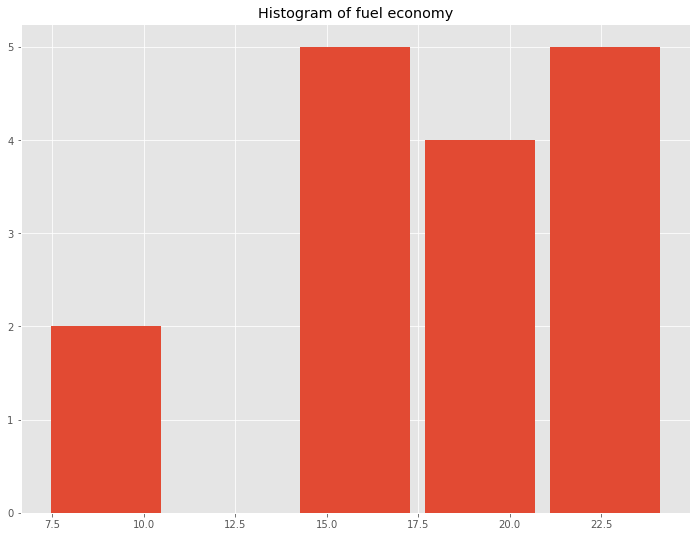

In [47]:
%%local

# Import the required library and set to use ggplot:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Plot:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(MPG_hist['bins'], MPG_hist['counts'], width=3)
ax.set_title('Histogram of fuel economy')

### Observation:

From the Histogram chart, it would seem like majority of the vehicle have a fuel economy of 15 mpg and above.

## 9.3 Using other Packages to plot the Histogram:

This section will utilise the "Bokeh" plotting library. NOTE: Make sure it is all in one code block.

To do this:
- Load in the required components of Bokeh
- Define the labels to put on the chart.
- Difine the figure with the parameters: 1st parameter is the "x_range" where it specifies the number of points on the x-axis. 2nd parameter is the "plot_height" that sets the height of the chart.
- Use the .vbar() function to produce the bars of the histogram. There are a few parameters: the 1st one is the "x" to put the labels on the plot and the 2nd parameter is "top" that specifies the counts.

### Set up Locally:

In [71]:
%%local

# Import the required packages:
from bokeh.io import show
from bokeh.plotting import figure 
from bokeh.io import output_notebook 
output_notebook()

# Define the labels:
labels = [str(round(e, 2)) for e in MPG_hist['bins']]

# Plot:
p = figure(
    x_range = labels,
    plot_height = 350,
    title = 'Histogram of fuel economy'
)

p.vbar(x = labels, top = MPG_hist['counts'], width = 0.9)
show(p)


Loading BokehJS ...

## 10 Visualising the Interactions between Features:

This section will explore how plotting the interactions between features can further develop understanding of the distribution of the data as well as how each of these features realte to each other.

## 10.1 Visualise the data with a Scatter Plot:

To do this:
- Select the features: here it will be 2 of them, Displacement and Cylinders
- Create a registering temporary table with " %%sql " magicto select all of the data from "scatter" table, expose it locally as a "scatter_source".
- Load in the required "Matplotlib" 
- Next, make a figure and add a subplot.
- Next, produce the scatter plot with the data, wher the x-axis is the number of cylinders and the y-axis is the displacement.
- Lastly, set the axes labels and chart title.

In [72]:
# Step 1 - Calculate for the Scatter plot:
Displ_Cyl_scatter_calc = (
    no_outliers_dat
    .select('Displacement', 'Cylinders')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
# Step 2 - Register the Temporary Table:
Displ_Cyl_scatter_calc.registerTempTable('scatter_plt')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### STEP 3 - Use Magic SQL

In [74]:
%%sql -o scatter_plt -q
SELECT * FROM scatter_plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Step 4 - Produce the Scatter Plot:

#### Set up locally:

Text(0.5, 1.0, 'Relationship between Cylinders and Displacement of Vehicles')

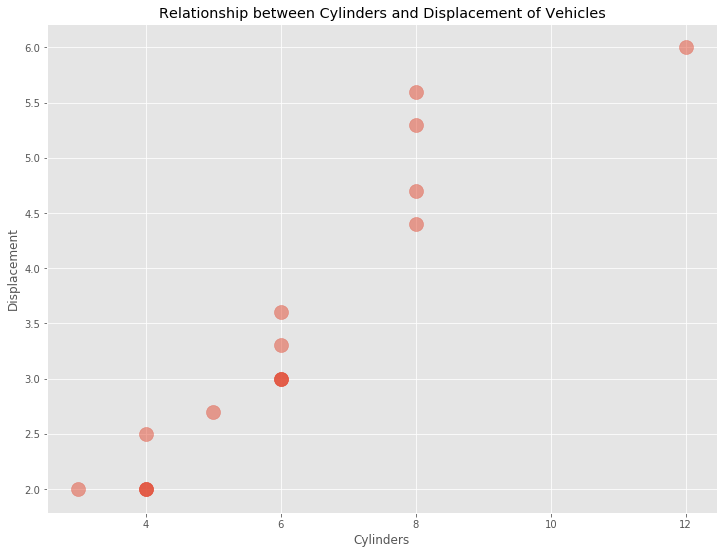

In [78]:
%%local

# Import the required library and set to use ggplot:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Plot:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(
    list(scatter_plt['Cylinders']), list(scatter_plt['Displacement']), s = 200, alpha = 0.5
)
ax.set_xlabel('Cylinders')
ax.set_ylabel('Displacement')
ax.set_title('Relationship between Cylinders and Displacement of Vehicles')

### Observation:

As it can be seen, there is almost a direct positive correlation between the number of cylinders and the displacement of the engine.


## 10.2 Scatter Plot with Bokeh:

### Setup locally:

In [79]:
%%local

# Import the required packages:
from bokeh.io import show
from bokeh.plotting import figure 
from bokeh.io import output_notebook 
output_notebook()

p = figure(title = 'Relationship between Cylinders and Displacement of Vehicles')
p.xaxis.axis_label = 'Cylinders'
p.yaxis.axis_label = 'Displacement'

p.circle(
    list(scatter_plt['Cylinders']), list(scatter_plt['Displacement']), fill_alpha = 0.2, size = 10
)

show(p)

Loading BokehJS ...

## Summary:

I was able to learn and develop a better understanding of data preparation, cleaning and visualisation with PySpark. These also includes on how to deal with problematic dataset sets. finding features that are useful and correlating them.